#Deep Learning (CSE641) Project
Team [Aadit Jha](mailto:aadit20001@iiitd.ac.in), [Niranjan S](mailto:niranjan20090@iiitd.ac.in), [Sahas Marwah](mailto:sahas20237@iiitd.ac.in) from IIIT-Delhi

Part 1 --- Implementation of __baselines__ for the task of __beat and downbeat estimation__ using deep neural architectures.

Baseline 1 --- A combination of implementations of [Bock et. al. ISMIR 2020](https://program.ismir2020.net/static/final_papers/223.pdf), [Bock et. al. ISMIR 2019](https://archives.ismir.net/ismir2019/paper/000058.pdf), and [Davies et. al. EUSIPCO 2019](https://www.eurasip.org/Proceedings/Eusipco/eusipco2019/Proceedings/papers/1570533824.pdf) with data augmentations.

NOTE --- We have directly borrowed the code from the [ISMIR 2021 tutorial](https://tempobeatdownbeat.github.io/tutorial/intro.html).

# ISMIR 2021 Tempo, Beat, and Downbeat Estimation Tutorial

This is the accompanying notebook for the Tempo, Beat, and Downbeat Estimation tutorial.

The book can be found here: https://tempobeatdownbeat.github.io/tutorial/intro.html



## Prerequisites

To run this notebook you need the following packages

- tensorflow
- keras
- madmom
- mirdata

All additionally needed packages should come as dependencies.

In [3]:
%matplotlib inline

In [4]:
%%capture
!pip install h5py==2.10.0
!pip install mido
!pip install madmom
!pip install mirdata
!pip install tensorflow-addons

## Google Drive

If you have a Google account and want to save the trained models or predictions, the easiest way is to mount your drive. Everything is then stored in your own drive.

In [5]:
# run the following commands if you want to save everything in your Google drive
from google.colab import drive

drive.mount('/content/drive/')
# set PATH to point to your Google Drive
PATH = '/content/drive/My Drive/'

Mounted at /content/drive/


## Setting up environment

We need to import some packages.

In [6]:
import os
import sys
import warnings

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import madmom
import mirdata
import librosa
import librosa.display

from scipy.ndimage import maximum_filter1d
from scipy.interpolate import interp1d
from scipy.signal import argrelmax

import matplotlib.pyplot as plt

In [7]:
# ignore certain warnings
warnings.filterwarnings('ignore')

# set default figure size
plt.rcParams['figure.figsize'] = (20, 6)

# Dataset handling

We use the well-known GTZAN dataset aus our dataset. This dataset comprises 1000 songs of 10 different genres.
We use a subset of 10 randomly chosen songs per genre as our "mini" dataset.
This greatly reduces the required training time, but also leads to decreased  (and less predictable) performance.

In [ ]:
# # Mini dataset
# gtzan = mirdata.initialize('gtzan_genre', version='mini')
# gtzan.download()
# len(gtzan.track_ids)

118MB [00:07, 16.5MB/s]
632kB [00:00, 1.28MB/s]


100

You can always use the full dataset to re-run the experiments by uncommenting the following cell.

In [8]:
# obtain copy of GTZAN data (use a mirror URL for faster access)
!pip install gdown
!mkdir -p /root/mir_datasets/gtzan_genre/gtzan_genre/
!gdown --id 1cwb2vAKryAYqkP2D86bpO6mbVlQmVhjN --output /root/mir_datasets/gtzan_genre/gtzan_genre/genres.tar.gz
# use the following line to initialise the dataset (i.e. the full version without 'mini')
gtzan = mirdata.initialize('gtzan_genre')
gtzan.download()
len(gtzan.track_ids)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1cwb2vAKryAYqkP2D86bpO6mbVlQmVhjN
To: /root/mir_datasets/gtzan_genre/gtzan_genre/genres.tar.gz
100% 1.23G/1.23G [00:16<00:00, 76.2MB/s]


632kB [00:00, 1.97MB/s] 


1000

## Define dataset splits

We split all tracks into two subsets, one used for training, the other for testing.
We use a 80/20 split, i.e. 80 songs for training and the remaining 20 for testing the model's performance on unseen data.

In [9]:
from sklearn.model_selection import train_test_split

tracks = gtzan.load_tracks()
train_files, test_files = train_test_split(list(tracks.keys()), test_size=0.3, random_state=1234)
val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=1234)
len(train_files), len(val_files), len(test_files), train_files[-1]

(700, 150, 150, 'pop.00015')

# Audio pre-processing

Our approach operates on a spectrogram representation of the audio signal.

We define a processor which transforms the raw audio into a spectrogram with 100 frames per second and 81 frequency bins.

In [10]:
from madmom.processors import ParallelProcessor, SequentialProcessor
from madmom.audio.signal import SignalProcessor, FramedSignalProcessor
from madmom.audio.stft import ShortTimeFourierTransformProcessor
from madmom.audio.spectrogram import FilteredSpectrogramProcessor, LogarithmicSpectrogramProcessor

FPS = 100
FFT_SIZE = 2048
NUM_BANDS = 12

# define pre-processor
class PreProcessor(SequentialProcessor):
    def __init__(self, frame_size=FFT_SIZE, num_bands=NUM_BANDS, log=np.log, add=1e-6, fps=FPS):
        # resample to a fixed sample rate in order to get always the same number of filter bins
        sig = SignalProcessor(num_channels=1, sample_rate=44100)
        # split audio signal in overlapping frames
        frames = FramedSignalProcessor(frame_size=frame_size, fps=fps)
        # compute STFT
        stft = ShortTimeFourierTransformProcessor()
        # filter the magnitudes
        filt = FilteredSpectrogramProcessor(num_bands=num_bands)
        # scale them logarithmically
        spec = LogarithmicSpectrogramProcessor(log=log, add=add)
        # instantiate a SequentialProcessor
        super(PreProcessor, self).__init__((sig, frames, stft, filt, spec, np.array))
        # safe fps as attribute (needed for quantization of events)
        self.fps = fps

# NN infrastructure

We create a multi-task model to jointly predict tempo, beats and doenbeats, which mostly follows our ISMIR 2020 paper "Deconstruct, analyse, reconstruct: how to improve tempo, beat, and downbeat estimation.".

In [11]:
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import (
    Activation,
    Dense,
    Input,
    Conv1D,
    Conv2D,
    MaxPooling2D,
    Reshape,
    Dropout,
    SpatialDropout1D,
    GaussianNoise,
    GlobalAveragePooling1D,
)
from keras.utils import Sequence
from keras.optimizers import Optimizer

## TCN network layers

The heart of the network is a TCN (temporal convolutional network) with 11 TCN layers with increasing dilation rates.

The structure is as follows:

![Multi-task TCN structure](https://docs.google.com/uc?export=download&id=1Mt-lig8CFmMRrSjbIF-DUhaBivIHZUtk)

In [12]:
def residual_block(x, i, activation, num_filters, kernel_size, padding, dropout_rate=0, name=''):
    # name of the layer
    name = name + '_dilation_%d' % i
    # 1x1 conv. of input (so it can be added as residual)
    res_x = Conv1D(num_filters, 1, padding='same', name=name + '_1x1_conv_residual')(x)
    # two dilated convolutions, with dilation rates of i and 2i
    conv_1 = Conv1D(
        filters=num_filters,
        kernel_size=kernel_size,
        dilation_rate=i,
        padding=padding,
        name=name + '_dilated_conv_1',
    )(x)
    conv_2 = Conv1D(
        filters=num_filters,
        kernel_size=kernel_size,
        dilation_rate=i * 2,
        padding=padding,
        name=name + '_dilated_conv_2',
    )(x)
    # concatenate the output of the two dilations
    concat = keras.layers.concatenate([conv_1, conv_2], name=name + '_concat')
    # apply activation function
    x = Activation(activation, name=name + '_activation')(concat)
    # apply spatial dropout
    x = SpatialDropout1D(dropout_rate, name=name + '_spatial_dropout_%f' % dropout_rate)(x)
    # 1x1 conv. to obtain a representation with the same size as the residual
    x = Conv1D(num_filters, 1, padding='same', name=name + '_1x1_conv')(x)
    # add the residual to the processed data and also return it as skip connection
    return keras.layers.add([res_x, x], name=name + '_merge_residual'), x


class TCN:
    def __init__(
        self,
        num_filters=20,
        kernel_size=5,
        dilations=[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
        activation='elu',
        padding='same',
        dropout_rate=0.15,
        name='tcn',
    ):
        self.name = name
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.dilations = dilations
        self.kernel_size = kernel_size
        self.num_filters = num_filters
        self.padding = padding

        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' padding are compatible for this layer.")

    def __call__(self, inputs):
        x = inputs
        # gather skip connections, each having a different context
        skip_connections = []
        # build the TCN models
        for i, num_filters in zip(self.dilations, self.num_filters):
            # feed the output of the previous layer into the next layer
            # increase dilation rate for each consecutive layer
            x, skip_out = residual_block(
                x, i, self.activation, num_filters, self.kernel_size, self.padding, self.dropout_rate, name=self.name
            )
            # collect skip connection
            skip_connections.append(skip_out)
        # activate the output of the TCN stack
        x = Activation(self.activation, name=self.name + '_activation')(x)
        # merge the skip connections by simply adding them
        skip = keras.layers.add(skip_connections, name=self.name + '_merge_skip_connections')
        return x, skip

## Multi-task model

The network to be trained consists of two main parts.
 1. a stack of convolutional layers, and
 2. the TCN itself.

The former is used to learn meaningful local features, whereas the latter learns the temporal dependencies of these (local) features.

In [13]:
def create_model(input_shape, num_filters=20, num_dilations=11, kernel_size=5, activation='elu', dropout_rate=0.15):
    # input layer
    input_layer = Input(shape=input_shape)
    # print(input_layer.shape)

    # stack of 3 conv layers, each conv, activation, max. pooling & dropout
    conv_1 = Conv2D(num_filters, (3, 3), padding='valid', name='conv_1_conv')(input_layer)
    conv_1 = Activation(activation, name='conv_1_activation')(conv_1)
    conv_1 = MaxPooling2D((1, 3), name='conv_1_max_pooling')(conv_1)
    conv_1 = Dropout(dropout_rate, name='conv_1_dropout')(conv_1)

    conv_2 = Conv2D(num_filters, (1, 10), padding='valid', name='conv_2_conv')(conv_1)
    conv_2 = Activation(activation, name='conv_2_activation')(conv_2)
    conv_2 = MaxPooling2D((1, 3), name='conv_2_max_pooling')(conv_2)
    conv_2 = Dropout(dropout_rate, name='conv_2_dropout')(conv_2)

    conv_3 = Conv2D(num_filters, (3, 3), padding='valid', name='conv_3_conv')(conv_2)
    conv_3 = Activation(activation, name='conv_3_activation')(conv_3)
    conv_3 = MaxPooling2D((1, 3), name='conv_3_max_pooling')(conv_3)
    conv_3 = Dropout(dropout_rate, name='conv_3_dropout')(conv_3)

    # reshape layer to reduce dimensions
    x = Reshape((-1, num_filters), name='tcn_input_reshape')(conv_3)

    # TCN layers
    dilations = [2 ** i for i in range(num_dilations)]
    tcn, skip = TCN(
        num_filters=[num_filters] * len(dilations),
        kernel_size=kernel_size,
        dilations=dilations,
        activation=activation,
        padding='same',
        dropout_rate=dropout_rate,
    )(x)

    # output layers; beats & downbeats use TCN output, tempo the skip connections
    beats = Dropout(dropout_rate, name='beats_dropout')(tcn)
    beats = Dense(1, name='beats_dense')(beats)
    beats = Activation('sigmoid', name='beats')(beats)

    downbeats = Dropout(dropout_rate, name='downbeats_dropout')(tcn)
    downbeats = Dense(1, name='downbeats_dense')(downbeats)
    downbeats = Activation('sigmoid', name='downbeats')(downbeats)

    tempo = Dropout(dropout_rate, name='tempo_dropout')(skip)
    tempo = GlobalAveragePooling1D(name='tempo_global_average_pooling')(tempo)
    tempo = GaussianNoise(dropout_rate, name='tempo_noise')(tempo)
    tempo = Dense(300, name='tempo_dense')(tempo)
    tempo = Activation('softmax', name='tempo')(tempo)

    # instantiate a Model and return it
    return Model(input_layer, outputs=[beats, downbeats, tempo])

## Data sequence handling

In order to be able to train our network, we need to provide the tracks in a way the network can deal with it.

Since our model needs to be able to process sequences (i.e. songs) of variable length, we use a batch size of 1.
Thus, no padding of the sequences is needed and we can simply iterate over them.

As features, we use a spectrogram representation, as targets we use the `beats`, `downbeats`, and `tempo` annotations of the songs.
Tempo information is always computed from the beats.

Beats and downbeats are one hot-encoded, i.e. frames representing a (down-)beat have a value of 1, all non-beat frames a value of 0.

Tempo is encoded as a vector with the bin representing the target tempo in bpm (beats per minute) having a value of 1, all other 0.

If there is no downbeat information, we mask the targets (all values set to -1).
This way the error can be ignored and is not backpropagated when updating the weights.

To improve training accuracy and speed, we "widen" the targets, i.e. give the neighbouring frames / tempo bins a value in between 0 and 1.

In [14]:
MASK_VALUE = -1

# infer (global) tempo from beats
def infer_tempo(beats, hist_smooth=15, fps=FPS, no_tempo=MASK_VALUE):
    ibis = np.diff(beats) * fps
    bins = np.bincount(np.round(ibis).astype(int))
    # if no beats are present, there is no tempo
    if not bins.any():
        return no_tempo
    intervals = np.arange(len(bins))
    # smooth histogram bins
    if hist_smooth > 0:
        bins = madmom.audio.signal.smooth(bins, hist_smooth)
    # create interpolation function
    interpolation_fn = interp1d(intervals, bins, 'quadratic')
    # generate new intervals with 1000x the resolution
    intervals = np.arange(intervals[0], intervals[-1], 0.001)
    tempi = 60.0 * fps / intervals
    # apply quadratic interpolation
    bins = interpolation_fn(intervals)
    peaks = argrelmax(bins, mode='wrap')[0]
    if len(peaks) == 0:
        # no peaks, no tempo
        return no_tempo
    else:
        # report only the strongest tempo
        sorted_peaks = peaks[np.argsort(bins[peaks])[::-1]]
        return tempi[sorted_peaks][0]


# pad features
def cnn_pad(data, pad_frames):
    """Pad the data by repeating the first and last frame N times."""
    pad_start = np.repeat(data[:1], pad_frames, axis=0)
    pad_stop = np.repeat(data[-1:], pad_frames, axis=0)
    return np.concatenate((pad_start, data, pad_stop))


# wrap training/test data as a Keras sequence so we can use it with fit_generator()
class DataSequence(Sequence):
    def __init__(self, tracks, pre_processor, num_tempo_bins=300, pad_frames=None):
        # store features and targets in dictionaries with name of the song as key
        self.x = {}
        self.beats = {}
        self.downbeats = {}
        self.tempo = {}
        self.pad_frames = pad_frames
        self.ids = []
        # iterate over all tracks
        for i, key in enumerate(tracks):
            # print progress
            sys.stderr.write(f'\rprocessing track {i + 1}/{len(tracks)}: {key + " " * 20}')
            sys.stderr.flush()
            t = tracks[key]
            try:
                # use track only if it contains beats
                beats = t.beats.times
                # wrap librosa wav data & sample rate as Signal
                s = madmom.audio.Signal(*t.audio)
                # compute features first to be able to quantize beats
                x = pre_processor(s)
                self.x[key] = x
                # quantize beats
                beats = madmom.utils.quantize_events(beats, fps=pre_processor.fps, length=len(x))
                self.beats[key] = beats
            except AttributeError:
                # no beats found, skip this file
                print(f'\r{key} has no beat information, skipping\n')
                continue
            # downbeats
            try:
                downbeats = t.beats.positions.astype(int) == 1
                downbeats = t.beats.times[downbeats]
                downbeats = madmom.utils.quantize_events(downbeats, fps=pre_processor.fps, length=len(x))
            except AttributeError:
                print(f'\r{key} has no downbeat information, masking\n')
                downbeats = np.ones(len(x), dtype='float32') * MASK_VALUE
            self.downbeats[key] = downbeats
            # tempo
            tempo = None
            try:
                # Note: to be able to augment a dataset, we need to scale the beat times
                tempo = infer_tempo(t.beats.times * pre_processor.fps / 100, fps=pre_processor.fps)
                tempo = keras.utils.to_categorical(int(np.round(tempo)), num_classes=num_tempo_bins, dtype='float32')
            except IndexError:
                # tempo out of bounds (too high)
                print(f'\r{key} has no valid tempo ({tempo}), masking\n')
                tempo = np.ones(num_tempo_bins, dtype='float32') * MASK_VALUE
            self.tempo[key] = tempo
            # keep track of IDs
            self.ids.append(key)
        assert len(self.x) == len(self.beats) == len(self.downbeats) == len(self.tempo) == len(self.ids)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # convert int idx to key
        if isinstance(idx, int):
            idx = self.ids[idx]
        # Note: we always use a batch size of 1 since the tracks have variable length
        #       keras expects the batch to be the first dimension, the prepend an axis;
        #       append an axis to beats and downbeats as well
        # define targets
        y = {}
        y['beats'] = self.beats[idx][np.newaxis, ..., np.newaxis]
        y['downbeats'] = self.downbeats[idx][np.newaxis, ..., np.newaxis]
        y['tempo'] = self.tempo[idx][np.newaxis, ...]
        # add context to frames
        x = self.x[idx]
        if self.pad_frames:
            x = cnn_pad(x, self.pad_frames)
        return x[np.newaxis, ..., np.newaxis], y

    def widen_beat_targets(self, size=3, value=0.5):
        for y in self.beats.values():
            # skip masked beat targets
            if np.allclose(y, MASK_VALUE):
                continue
            np.maximum(y, maximum_filter1d(y, size=size) * value, out=y)

    def widen_downbeat_targets(self, size=3, value=0.5):
        for y in self.downbeats.values():
            # skip masked downbeat targets
            if np.allclose(y, MASK_VALUE):
                continue
            np.maximum(y, maximum_filter1d(y, size=size) * value, out=y)

    def widen_tempo_targets(self, size=3, value=0.5):
        for y in self.tempo.values():
            # skip masked tempo targets
            if np.allclose(y, MASK_VALUE):
                continue
            np.maximum(y, maximum_filter1d(y, size=size) * value, out=y)

    def append(self, other):
        assert not any(key in self.ids for key in other.ids), 'IDs must be unique'
        self.x.update(other.x)
        self.beats.update(other.beats)
        self.downbeats.update(other.downbeats)
        self.tempo.update(other.tempo)
        self.ids.extend(other.ids)

## Loss & metrics

We train our model with cross entropy, but need to mask the loss function and metrics if the targets are set to be ignored (i.e. no tempo / downbeat information at hand).

In [15]:
# https://github.com/keras-team/keras/issues/3893
def build_masked_loss(loss_function, mask_value=MASK_VALUE):
    """Builds a loss function that masks based on targets

    Args:
        loss_function: The loss function to mask
        mask_value: The value to mask in the targets

    Returns:
        function: a loss function that acts like loss_function with masked inputs
    """

    def masked_loss_function(y_true, y_pred):
        mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
        return loss_function(y_true * mask, y_pred * mask)

    return masked_loss_function


def masked_accuracy(y_true, y_pred):
    total = K.sum(K.not_equal(y_true, MASK_VALUE))
    correct = K.sum(K.equal(y_true, K.round(y_pred)))
    return correct / total

# Train network

## Training & testing sequences

We wrap our previously split dataset as `DataSequences`.

We widen the beat and downbeat targets to have a value of 0.5 at the frames next to the annotated beat locations.

We assign tempo values ±1 bpm apart a value of 0.5, and those ±2bpm a value of0.25.

In [45]:
pad_frames = 2
pre_processor = PreProcessor()

In [46]:
# # Uncomment if you want to train the network once again

# train = DataSequence(
#     tracks={k: v for k, v in tracks.items() if k in train_files}, pre_processor=pre_processor, pad_frames=pad_frames
# )
# train.widen_beat_targets()
# train.widen_downbeat_targets()
# train.widen_tempo_targets()
# train.widen_tempo_targets()

processing track 274/700: jazz.00004                    

jazz.00003 has no downbeat information, masking



processing track 278/700: jazz.00010                    

jazz.00009 has no downbeat information, masking



processing track 279/700: jazz.00011                    

jazz.00010 has no downbeat information, masking



processing track 284/700: jazz.00019                    

jazz.00018 has no downbeat information, masking



processing track 286/700: jazz.00021                    

jazz.00020 has no downbeat information, masking



processing track 293/700: jazz.00032                    

jazz.00031 has no valid tempo (344.6691176470588), masking



processing track 545/700: reggae.00087                    

reggae.00086 has no beat information, skipping



processing track 700/700: metal.00098                    

In [47]:
val = DataSequence(
    tracks={k: v for k, v in tracks.items() if k in val_files}, pre_processor=pre_processor, pad_frames=pad_frames
)
val.widen_beat_targets()
val.widen_downbeat_targets()
val.widen_tempo_targets()
val.widen_tempo_targets()

test = DataSequence(
    tracks={k: v for k, v in tracks.items() if k in test_files}, pre_processor=pre_processor, pad_frames=pad_frames
)
test.widen_beat_targets()
test.widen_downbeat_targets()
test.widen_tempo_targets()
test.widen_tempo_targets()

processing track 72/150: jazz.00016                    

jazz.00014 has no downbeat information, masking



processing track 150/150: metal.00087                    

## Visualise validation data

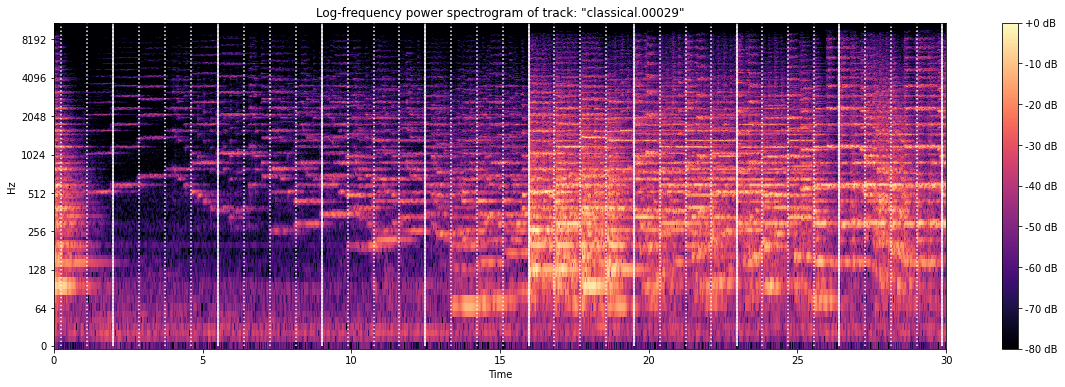

In [20]:
song = val.ids[0]

track = tracks[song]
audio, sr = track.audio
hop_length = 512

spec = librosa.amplitude_to_db(np.abs(librosa.stft(audio, hop_length=hop_length)), ref=np.max)
img = librosa.display.specshow(spec, y_axis='log', sr=sr, hop_length=hop_length, x_axis='time')
plt.vlines(track.beats.times, 0, sr / 2, linestyles='dotted', color='w')
plt.vlines(track.beats.times[track.beats.positions == 1], 0, sr / 2, color='w')
plt.title(f'Log-frequency power spectrogram of track: "{song}"')
plt.colorbar(format="%+2.f dB")
plt.show()

## Put everything together

Finally create the network, add an optimizer, loss functions and metrics to it, and compile the graph.

In [52]:
# use a validation sample to infer input shape
input_shape = (None,) + val[0][0].shape[-2:]
model = create_model(input_shape)

learnrate = 0.005
clipnorm = 0.5

optimizer = tfa.optimizers.RectifiedAdam(lr=learnrate, clipnorm=clipnorm)
optimizer = tfa.optimizers.Lookahead(optimizer, sync_period=5, slow_step_size=0.5)

model.compile(
    optimizer=optimizer,
    loss=[
        build_masked_loss(K.binary_crossentropy),
        build_masked_loss(K.binary_crossentropy),
        build_masked_loss(K.binary_crossentropy),
    ],
    metrics=['binary_accuracy'],
)
model.summary(200)

Model: "model_1"
________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                     Output Shape                                Param #                 Connected to                                                      
 input_2 (InputLayer)                                             [(None, None, 81, 1)]                       0                       []                                                                
                                                                                                                                                                                                        
 conv_1_conv (Conv2D)                                             (None, None, 79, 20)                        200                     ['input_2[0][0]']                            

## Train network

We train the network for 100 epochs, each epoch randomly iterating over all sequences (i.e. songs) of the dataset.

Whenever a better performance is observed (i.e. lower loss), we store the model.

If the performance does not increase for a certain number of epochs, we reduce the learnrate by a factor of 5.
If no further improvement can be observed, we stop the training (early stopping).

We log everything to a Tensorboard log.

In [ ]:
# # RUN ONLY IF YOU WANT TO TRAIN
# setting = 'baseline_1_train_attempt_2'
# epochs = 100
# verbose = 0

# # create output dir
# outdir = f'{PATH}Datasets/DL/Project/{setting}'
# os.makedirs(outdir, exist_ok=True)
# print(f'output dir: {outdir}')

# # model checkpointing
# mc = keras.callbacks.ModelCheckpoint(f'{outdir}/model_best.h5', monitor='loss', save_best_only=True, verbose=verbose)

# # learn rate scheduler
# lr = keras.callbacks.ReduceLROnPlateau(
#     monitor='loss', factor=0.2, patience=10, verbose=1, mode='auto', min_delta=1e-3, cooldown=0, min_lr=1e-7
# )

# # early stopping
# es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-4, patience=20, verbose=verbose)

# # tensorboard logging
# tb = keras.callbacks.TensorBoard(log_dir=f'{outdir}/logs', write_graph=True, write_images=True)

# # actually train network
# history = model.fit_generator(
#     train,
#     steps_per_epoch=len(train),
#     epochs=epochs,
#     shuffle=True,
#     validation_data=val,
#     validation_steps=len(val),
#     callbacks=[mc, es, tb, lr],
# )
# model.save(f'{outdir}/model_final.h5')

output dir: /content/drive/My Drive/Datasets/DL/Project/baseline_1_train_attempt_1
Epoch 1/100
699/699 [==============================] - 89s 74ms/step - loss: 0.3559 - beats_loss: 0.2186 - downbeats_loss: 0.0820 - tempo_loss: 0.0553 - beats_binary_accuracy: 0.9361 - downbeats_binary_accuracy: 0.9745 - tempo_binary_accuracy: 0.9818 - val_loss: 0.2264 - val_beats_loss: 0.1306 - val_downbeats_loss: 0.0499 - val_tempo_loss: 0.0458 - val_beats_binary_accuracy: 0.9409 - val_downbeats_binary_accuracy: 0.9848 - val_tempo_binary_accuracy: 0.9833 - lr: 0.0050
Epoch 2/100
699/699 [==============================] - 45s 65ms/step - loss: 0.2299 - beats_loss: 0.1327 - downbeats_loss: 0.0515 - tempo_loss: 0.0457 - beats_binary_accuracy: 0.9394 - downbeats_binary_accuracy: 0.9776 - tempo_binary_accuracy: 0.9819 - val_loss: 0.2094 - val_beats_loss: 0.1186 - val_downbeats_loss: 0.0456 - val_tempo_loss: 0.0452 - val_beats_binary_accuracy: 0.9409 - val_downbeats_binary_accuracy: 0.9848 - val_tempo_binary

# Post-processing

After training has finished, the model is able to predict beats, downbeats, and tempo.

The performance can be greatly improved by post-processing the raw outputs of the network.

For beats and downbeats a dynamic Bayesian network approach is chosen.
Tempo output is only smoothed and interpolated to determine the final tempo in BPM.

In [22]:
# track beats with a DBN
beat_tracker = madmom.features.beats.DBNBeatTrackingProcessor(
    min_bpm=55.0, max_bpm=215.0, fps=FPS, transition_lambda=100, threshold=0.05
)

# track downbeats with a DBN
# as input, use a combined beat & downbeat activation function
downbeat_tracker = madmom.features.downbeats.DBNDownBeatTrackingProcessor(
    beats_per_bar=[3, 4], min_bpm=55.0, max_bpm=215.0, fps=FPS, transition_lambda=100
)

# track bars, i.e. first track the beats and then infer the downbeat positions
bar_tracker = madmom.features.downbeats.DBNBarTrackingProcessor(
    beats_per_bar=(3, 4), meter_change_prob=1e-3, observation_weight=4
)

In [23]:
def detect_tempo(bins, hist_smooth=11, min_bpm=10):
    min_bpm = int(np.floor(min_bpm))
    tempi = np.arange(min_bpm, len(bins))
    bins = bins[min_bpm:]
    # smooth histogram bins
    if hist_smooth > 0:
        bins = madmom.audio.signal.smooth(bins, hist_smooth)
    # create interpolation function
    interpolation_fn = interp1d(tempi, bins, 'quadratic')
    # generate new intervals with 1000x the resolution
    tempi = np.arange(tempi[0], tempi[-1], 0.001)
    # apply quadratic interpolation
    bins = interpolation_fn(tempi)
    peaks = argrelmax(bins, mode='wrap')[0]
    if len(peaks) == 0:
        # no peaks, no tempo
        tempi = np.array([], ndmin=2)
    elif len(peaks) == 1:
        # report only the strongest tempo
        ret = np.array([tempi[peaks[0]], 1.0])
        tempi = np.array([tempi[peaks[0]], 1.0])
    else:
        # sort the peaks in descending order of bin heights
        sorted_peaks = peaks[np.argsort(bins[peaks])[::-1]]
        # normalize their strengths
        strengths = bins[sorted_peaks]
        strengths /= np.sum(strengths)
        # return the tempi and their normalized strengths
        ret = np.array(list(zip(tempi[sorted_peaks], strengths)))
        tempi = np.array(list(zip(tempi[sorted_peaks], strengths)))
    return tempi[:2]

In [32]:
# function to predict the model's output(s), post-process everything and save if needed
def predict(model, dataset, detdir=None, activations={}, detections={}):

    for i, t in enumerate(dataset):
        # file name
        f = dataset.ids[i]
        # print progress
        sys.stderr.write('processing file %d of %d: %12s \n' % (i + 1, len(dataset), f))
        sys.stderr.flush()
        # predict activations
        x = t[0]
        ## x = (1, 3006, 81, 1)
        beats, downbeats, tempo = model.predict(x)
        ## beats/downbeats/tempo = (1, 3002, 1) (1, 3002, 1) (1, 300)
        beats_act = beats.squeeze()
        downbeats_act = downbeats.squeeze()
        tempo_act = tempo.squeeze()
        # beats
        beats = beat_tracker(beats_act)
        ## beats = (64) number of positions where the beat is activated
        # downbeats
        combined_act = np.vstack((np.maximum(beats_act - downbeats_act, 0), downbeats_act)).T
        downbeats = downbeat_tracker(combined_act)
        # bars (i.e. track beats and then downbeats)
        beat_idx = (beats * FPS).astype(np.int)
        bar_act = maximum_filter1d(downbeats_act, size=3)
        bar_act = bar_act[beat_idx]
        bar_act = np.vstack((beats, bar_act)).T
        try:
            bars = bar_tracker(bar_act)
        except IndexError:
            bars = np.empty((0, 2))
        # tempo
        tempo = detect_tempo(tempo_act)

        # collect activations and detections
        activations[f] = {'beats': beats_act, 'downbeats': downbeats_act, 'combined': combined_act, 'tempo': tempo_act}
        detections[f] = {'beats': beats, 'downbeats': downbeats, 'bars': bars, 'tempo': tempo}

        # save activations & detections
        if detdir is not None:
            os.makedirs(detdir, exist_ok=True)
            np.save('%s/%s.beats.npy' % (detdir, f), beats_act)
            np.save('%s/%s.downbeats.npy' % (detdir, f), downbeats_act)
            np.save('%s/%s.tempo.npy' % (detdir, f), tempo_act)
            madmom.io.write_beats(beats, '%s/%s.beats.txt' % (detdir, f))
            madmom.io.write_beats(downbeats, '%s/%s.downbeats.txt' % (detdir, f))
            madmom.io.write_beats(bars, '%s/%s.bars.txt' % (detdir, f))
            madmom.io.write_tempo(tempo, '%s/%s.bpm.txt' % (detdir, f))

    return activations, detections

### Predict on test set

Loading of model is only needed if model is not defined, i.e. it was trained in a previous run of the notebook.

In [33]:
# if training did not finish, but was almost there, use `model_best.h5` instead of `model_final.h5`
setting = 'baseline_1_train_attempt_1'
outdir = f'{PATH}Datasets/DL/Project/{setting}'
print(f'output dir: {outdir}')
# model = keras.models.load_model(f'{outdir}/model_best.h5', compile=False)
model = keras.models.load_model(f'{outdir}/model_final.h5', compile=False)

output dir: /content/drive/My Drive/Datasets/DL/Project/baseline_1_train_attempt_1


Predict the model's activations (i.e. the raw outputs) and the post-processed detections.

In [34]:
# create a directory to put the activations and detections into
detdir = f'{outdir}/detections/'

# we can use validation set as test set, since we did not use it for anything besides monitoring progress
activations, detections = predict(model, test, detdir)

processing file 1 of 150: classical.00007 


1/1 [==============================] - 1s 1s/step


processing file 2 of 150: classical.00008 


1/1 [==============================] - 0s 44ms/step


processing file 3 of 150: classical.00009 


1/1 [==============================] - 0s 34ms/step


processing file 4 of 150: classical.00011 


1/1 [==============================] - 0s 24ms/step


processing file 5 of 150: classical.00021 


1/1 [==============================] - 0s 24ms/step


processing file 6 of 150: classical.00024 


1/1 [==============================] - 0s 23ms/step


processing file 7 of 150: classical.00042 


1/1 [==============================] - 1s 1s/step


processing file 8 of 150: classical.00047 


1/1 [==============================] - 0s 27ms/step


processing file 9 of 150: classical.00060 


1/1 [==============================] - 0s 24ms/step


processing file 10 of 150: classical.00062 


1/1 [==============================] - 0s 27ms/step


processing file 11 of 150: classical.00065 


1/1 [==============================] - 0s 24ms/step


processing file 12 of 150: classical.00066 


1/1 [==============================] - 0s 24ms/step


processing file 13 of 150: classical.00067 


1/1 [==============================] - 0s 25ms/step


processing file 14 of 150: classical.00072 


1/1 [==============================] - 0s 33ms/step


processing file 15 of 150: classical.00078 


1/1 [==============================] - 0s 24ms/step


processing file 16 of 150: classical.00083 


1/1 [==============================] - 0s 24ms/step


processing file 17 of 150: classical.00089 


1/1 [==============================] - 0s 25ms/step


processing file 18 of 150: classical.00093 


1/1 [==============================] - 0s 40ms/step


processing file 19 of 150: classical.00099 


1/1 [==============================] - 0s 37ms/step


processing file 20 of 150: country.00000 


1/1 [==============================] - 0s 40ms/step


processing file 21 of 150: country.00008 


1/1 [==============================] - 0s 45ms/step


processing file 22 of 150: country.00009 


1/1 [==============================] - 0s 25ms/step


processing file 23 of 150: country.00018 


1/1 [==============================] - 0s 25ms/step


processing file 24 of 150: country.00024 


1/1 [==============================] - 0s 23ms/step


processing file 25 of 150: country.00028 


1/1 [==============================] - 0s 23ms/step


processing file 26 of 150: country.00037 


1/1 [==============================] - 0s 27ms/step


processing file 27 of 150: country.00041 


1/1 [==============================] - 0s 25ms/step


processing file 28 of 150: country.00043 


1/1 [==============================] - 0s 25ms/step


processing file 29 of 150: country.00046 


1/1 [==============================] - 0s 23ms/step


processing file 30 of 150: country.00047 


1/1 [==============================] - 0s 24ms/step


processing file 31 of 150: country.00048 


1/1 [==============================] - 0s 23ms/step


processing file 32 of 150: country.00056 


1/1 [==============================] - 0s 24ms/step


processing file 33 of 150: country.00059 


1/1 [==============================] - 0s 25ms/step


processing file 34 of 150: country.00060 


1/1 [==============================] - 0s 24ms/step


processing file 35 of 150: country.00075 


1/1 [==============================] - 0s 27ms/step


processing file 36 of 150: country.00076 


1/1 [==============================] - 0s 25ms/step


processing file 37 of 150: country.00087 


1/1 [==============================] - 0s 28ms/step


processing file 38 of 150: country.00088 


1/1 [==============================] - 0s 26ms/step


processing file 39 of 150:  disco.00005 


1/1 [==============================] - 0s 38ms/step


processing file 40 of 150:  disco.00006 


1/1 [==============================] - 0s 41ms/step


processing file 41 of 150:  disco.00014 


1/1 [==============================] - 0s 39ms/step


processing file 42 of 150:  disco.00019 


1/1 [==============================] - 0s 24ms/step


processing file 43 of 150:  disco.00026 


1/1 [==============================] - 0s 26ms/step


processing file 44 of 150:  disco.00027 


1/1 [==============================] - 0s 25ms/step


processing file 45 of 150:  disco.00030 


1/1 [==============================] - 0s 24ms/step


processing file 46 of 150:  disco.00040 


1/1 [==============================] - 0s 23ms/step


processing file 47 of 150:  disco.00045 


1/1 [==============================] - 0s 24ms/step


processing file 48 of 150:  disco.00062 


1/1 [==============================] - 0s 26ms/step


processing file 49 of 150:  disco.00066 


1/1 [==============================] - 0s 24ms/step


processing file 50 of 150:  disco.00071 


1/1 [==============================] - 0s 32ms/step


processing file 51 of 150:  disco.00072 


1/1 [==============================] - 0s 25ms/step


processing file 52 of 150:  disco.00081 


1/1 [==============================] - 0s 33ms/step


processing file 53 of 150:  disco.00087 


1/1 [==============================] - 0s 27ms/step


processing file 54 of 150: hiphop.00007 


1/1 [==============================] - 0s 24ms/step


processing file 55 of 150: hiphop.00010 


1/1 [==============================] - 0s 25ms/step


processing file 56 of 150: hiphop.00015 


1/1 [==============================] - 0s 25ms/step


processing file 57 of 150: hiphop.00019 


1/1 [==============================] - 0s 27ms/step


processing file 58 of 150: hiphop.00020 


1/1 [==============================] - 0s 24ms/step


processing file 59 of 150: hiphop.00022 


1/1 [==============================] - 0s 33ms/step


processing file 60 of 150: hiphop.00026 


1/1 [==============================] - 0s 35ms/step


processing file 61 of 150: hiphop.00041 


1/1 [==============================] - 0s 40ms/step


processing file 62 of 150: hiphop.00057 


1/1 [==============================] - 0s 24ms/step


processing file 63 of 150: hiphop.00063 


1/1 [==============================] - 0s 23ms/step


processing file 64 of 150: hiphop.00066 


1/1 [==============================] - 0s 23ms/step


processing file 65 of 150: hiphop.00073 


1/1 [==============================] - 0s 23ms/step


processing file 66 of 150: hiphop.00075 


1/1 [==============================] - 0s 25ms/step


processing file 67 of 150: hiphop.00078 


1/1 [==============================] - 0s 28ms/step


processing file 68 of 150: hiphop.00082 


1/1 [==============================] - 0s 25ms/step


processing file 69 of 150: hiphop.00095 


1/1 [==============================] - 0s 25ms/step


processing file 70 of 150:   jazz.00013 


1/1 [==============================] - 0s 28ms/step


processing file 71 of 150:   jazz.00014 


1/1 [==============================] - 0s 24ms/step


processing file 72 of 150:   jazz.00016 


1/1 [==============================] - 0s 38ms/step


processing file 73 of 150:   jazz.00023 


1/1 [==============================] - 0s 23ms/step


processing file 74 of 150:   jazz.00027 


1/1 [==============================] - 0s 24ms/step


processing file 75 of 150:   jazz.00028 


1/1 [==============================] - 0s 25ms/step


processing file 76 of 150:   jazz.00043 


1/1 [==============================] - 0s 25ms/step


processing file 77 of 150:   jazz.00044 


1/1 [==============================] - 0s 29ms/step


processing file 78 of 150:   jazz.00053 


1/1 [==============================] - 0s 48ms/step


processing file 79 of 150:   jazz.00073 


1/1 [==============================] - 0s 43ms/step


processing file 80 of 150:   jazz.00084 


1/1 [==============================] - 0s 40ms/step


processing file 81 of 150:   jazz.00085 


1/1 [==============================] - 0s 36ms/step


processing file 82 of 150:   jazz.00092 


1/1 [==============================] - 0s 28ms/step


processing file 83 of 150:   rock.00002 


1/1 [==============================] - 0s 25ms/step


processing file 84 of 150:   rock.00023 


1/1 [==============================] - 0s 26ms/step


processing file 85 of 150:   rock.00025 


1/1 [==============================] - 0s 27ms/step


processing file 86 of 150:   rock.00036 


1/1 [==============================] - 0s 25ms/step


processing file 87 of 150:   rock.00037 


1/1 [==============================] - 0s 30ms/step


processing file 88 of 150:   rock.00055 


1/1 [==============================] - 0s 25ms/step


processing file 89 of 150:   rock.00076 


1/1 [==============================] - 0s 28ms/step


processing file 90 of 150:   rock.00078 


1/1 [==============================] - 0s 25ms/step


processing file 91 of 150:   rock.00081 


1/1 [==============================] - 0s 24ms/step


processing file 92 of 150:   rock.00082 


1/1 [==============================] - 0s 23ms/step


processing file 93 of 150:   rock.00087 


1/1 [==============================] - 0s 24ms/step


processing file 94 of 150:   rock.00089 


1/1 [==============================] - 0s 25ms/step


processing file 95 of 150:  blues.00007 


1/1 [==============================] - 0s 25ms/step


processing file 96 of 150:  blues.00018 


1/1 [==============================] - 0s 26ms/step


processing file 97 of 150:  blues.00032 


1/1 [==============================] - 0s 24ms/step


processing file 98 of 150:  blues.00035 


1/1 [==============================] - 0s 39ms/step


processing file 99 of 150:  blues.00037 


1/1 [==============================] - 0s 35ms/step


processing file 100 of 150:  blues.00052 


1/1 [==============================] - 0s 34ms/step


processing file 101 of 150:  blues.00075 


1/1 [==============================] - 0s 36ms/step


processing file 102 of 150:  blues.00076 


1/1 [==============================] - 0s 23ms/step


processing file 103 of 150:  blues.00078 


1/1 [==============================] - 0s 24ms/step


processing file 104 of 150:  blues.00088 


1/1 [==============================] - 0s 25ms/step


processing file 105 of 150:  blues.00098 


1/1 [==============================] - 0s 24ms/step


processing file 106 of 150: reggae.00004 


1/1 [==============================] - 0s 26ms/step


processing file 107 of 150: reggae.00009 


1/1 [==============================] - 0s 23ms/step


processing file 108 of 150: reggae.00012 


1/1 [==============================] - 0s 24ms/step


processing file 109 of 150: reggae.00015 


1/1 [==============================] - 0s 25ms/step


processing file 110 of 150: reggae.00020 


1/1 [==============================] - 0s 26ms/step


processing file 111 of 150: reggae.00025 


1/1 [==============================] - 0s 26ms/step


processing file 112 of 150: reggae.00039 


1/1 [==============================] - 0s 31ms/step


processing file 113 of 150: reggae.00042 


1/1 [==============================] - 0s 24ms/step


processing file 114 of 150: reggae.00065 


1/1 [==============================] - 0s 30ms/step


processing file 115 of 150: reggae.00067 


1/1 [==============================] - 0s 27ms/step


processing file 116 of 150: reggae.00073 


1/1 [==============================] - 0s 26ms/step


processing file 117 of 150: reggae.00074 


1/1 [==============================] - 0s 25ms/step


processing file 118 of 150: reggae.00082 


1/1 [==============================] - 0s 42ms/step


processing file 119 of 150: reggae.00090 


1/1 [==============================] - 0s 35ms/step


processing file 120 of 150:    pop.00009 


1/1 [==============================] - 0s 36ms/step


processing file 121 of 150:    pop.00033 


1/1 [==============================] - 0s 40ms/step


processing file 122 of 150:    pop.00035 


1/1 [==============================] - 0s 24ms/step


processing file 123 of 150:    pop.00044 


1/1 [==============================] - 0s 25ms/step


processing file 124 of 150:    pop.00048 


1/1 [==============================] - 0s 27ms/step


processing file 125 of 150:    pop.00053 


1/1 [==============================] - 0s 31ms/step


processing file 126 of 150:    pop.00060 


1/1 [==============================] - 0s 26ms/step


processing file 127 of 150:    pop.00061 


1/1 [==============================] - 0s 24ms/step


processing file 128 of 150:    pop.00078 


1/1 [==============================] - 0s 39ms/step


processing file 129 of 150:    pop.00081 


1/1 [==============================] - 0s 25ms/step


processing file 130 of 150:    pop.00082 


1/1 [==============================] - 0s 24ms/step


processing file 131 of 150:    pop.00083 


1/1 [==============================] - 0s 31ms/step


processing file 132 of 150:    pop.00085 


1/1 [==============================] - 0s 27ms/step


processing file 133 of 150:    pop.00087 


1/1 [==============================] - 0s 25ms/step


processing file 134 of 150:    pop.00088 


1/1 [==============================] - 0s 38ms/step


processing file 135 of 150:    pop.00095 


1/1 [==============================] - 0s 47ms/step


processing file 136 of 150:    pop.00099 


1/1 [==============================] - 0s 27ms/step


processing file 137 of 150:  metal.00002 


1/1 [==============================] - 0s 25ms/step


processing file 138 of 150:  metal.00005 


1/1 [==============================] - 0s 25ms/step


processing file 139 of 150:  metal.00006 


1/1 [==============================] - 0s 25ms/step


processing file 140 of 150:  metal.00007 


1/1 [==============================] - 0s 24ms/step


processing file 141 of 150:  metal.00029 


1/1 [==============================] - 0s 45ms/step


processing file 142 of 150:  metal.00032 


1/1 [==============================] - 0s 26ms/step


processing file 143 of 150:  metal.00033 


1/1 [==============================] - 0s 40ms/step


processing file 144 of 150:  metal.00036 


1/1 [==============================] - 0s 45ms/step


processing file 145 of 150:  metal.00052 


1/1 [==============================] - 0s 25ms/step


processing file 146 of 150:  metal.00053 


1/1 [==============================] - 0s 24ms/step


processing file 147 of 150:  metal.00058 


1/1 [==============================] - 0s 23ms/step


processing file 148 of 150:  metal.00072 


1/1 [==============================] - 0s 44ms/step


processing file 149 of 150:  metal.00083 


1/1 [==============================] - 0s 29ms/step


processing file 150 of 150:  metal.00087 


1/1 [==============================] - 0s 25ms/step


# Evaluation


In [35]:
def evaluate_beats(detections, annotations):
    evals = []
    for key, det in detections.items():
        ann = annotations[key]
        e = madmom.evaluation.beats.BeatEvaluation(det, ann)
        evals.append(e)
    return madmom.evaluation.beats.BeatMeanEvaluation(evals)


def evaluate_downbeats(detections, annotations):
    evals = []
    for key, det in detections.items():
        ann = annotations[key]
        e = madmom.evaluation.beats.BeatEvaluation(det, ann, downbeats=True)
        evals.append(e)
    return madmom.evaluation.beats.BeatMeanEvaluation(evals)


def evaluate_tempo(detections, annotations):
    evals = []
    for key, det in detections.items():
        ann = annotations[key]
        e = madmom.evaluation.tempo.TempoEvaluation(det, ann)
        evals.append(e)
    return madmom.evaluation.tempo.TempoMeanEvaluation(evals)

## Evaluate beats & tempo

In [36]:
beat_detections = {k: v['beats'] for k, v in detections.items()}
downbeat_detections = {k: v['downbeats'] for k, v in detections.items()}
bar_detections = {k: v['bars'] for k, v in detections.items()}
tempo_detections = {k: v['tempo'][0, 0] for k, v in detections.items()}

beat_annotations = {k: v.beats.times for k, v in tracks.items() if v.beats is not None}
downbeat_annotations = {k: v.beats.times[v.beats.positions == 1] for k, v in tracks.items() if v.beats is not None}
tempo_annotations = {k: v.tempo for k, v in tracks.items() if v.tempo is not None}

# evaluate beats
print('Beat evaluation\n---------------')
print(' Beat tracker:    ', evaluate_beats(beat_detections, beat_annotations))
print(' Downbeat tracker:', evaluate_beats(downbeat_detections, beat_annotations))

# evaluate downbeats
print('\nDownbeat evaluation\n-------------------')
print(' Bar tracker:     ', evaluate_downbeats(bar_detections, downbeat_annotations))
print(' Downbeat tracker:', evaluate_downbeats(downbeat_detections, downbeat_annotations))

# evaluate tempo
print('\nTempo evaluation\n----------------')
print(' Tempo:           ', evaluate_tempo(tempo_detections, tempo_annotations))

Beat evaluation
---------------
 Beat tracker:     mean for 150 files
  F-measure: 0.882 P-score: 0.875 Cemgil: 0.829 Goto: 0.827 CMLc: 0.785 CMLt: 0.809 AMLc: 0.888 AMLt: 0.919 D: 3.282 Dg: 2.207
 Downbeat tracker: mean for 150 files
  F-measure: 0.880 P-score: 0.871 Cemgil: 0.827 Goto: 0.827 CMLc: 0.781 CMLt: 0.800 AMLc: 0.891 AMLt: 0.918 D: 3.251 Dg: 2.191

Downbeat evaluation
-------------------
 Bar tracker:      mean for 150 files
  F-measure: 0.582 P-score: 0.603 Cemgil: 0.551 Goto: 0.567 CMLc: 0.563 CMLt: 0.563 AMLc: 0.799 AMLt: 0.801 D: 4.519 Dg: 2.339
 Downbeat tracker: mean for 150 files
  F-measure: 0.579 P-score: 0.601 Cemgil: 0.548 Goto: 0.560 CMLc: 0.552 CMLt: 0.552 AMLc: 0.817 AMLt: 0.819 D: 4.499 Dg: 2.402

Tempo evaluation
----------------
 Tempo:            mean for 150 files
  pscore=0.847 (one tempo: 0.847, all tempi: 0.847) acc1=0.847 acc2=0.933


(ISMIR 2021 Tutorial) For reference, a model trained on the full GTZAN dataset has the following performance:
```
Beat evaluation
---------------
 Beats:     mean for 20 files
  F-measure: 0.767 P-score: 0.740 Cemgil: 0.696 Goto: 0.650 CMLc: 0.536 CMLt: 0.580 AMLc: 0.748 AMLt: 0.811 D: 2.817 Dg: 1.686
 Downbeats: mean for 20 files
  F-measure: 0.789 P-score: 0.765 Cemgil: 0.714 Goto: 0.700 CMLc: 0.597 CMLt: 0.636 AMLc: 0.761 AMLt: 0.816 D: 2.887 Dg: 1.723

Downbeat evaluation
-------------------
 Bars:      mean for 20 files
  F-measure: 0.483 P-score: 0.536 Cemgil: 0.443 Goto: 0.550 CMLc: 0.406 CMLt: 0.415 AMLc: 0.756 AMLt: 0.764 D: 3.963 Dg: 2.039
 Downbeats: mean for 20 files
  F-measure: 0.566 P-score: 0.619 Cemgil: 0.522 Goto: 0.650 CMLc: 0.529 CMLt: 0.529 AMLc: 0.788 AMLt: 0.788 D: 4.013 Dg: 2.085

Tempo evaluation
----------------
 Tempo:      mean for 20 files
  pscore=0.650 (one tempo: 0.650, all tempi: 0.650) acc1=0.650 acc2=0.900
```

Our Model
```
Beat evaluation
---------------
 Beat tracker:     mean for 150 files
  F-measure: 0.882 P-score: 0.875 Cemgil: 0.829 Goto: 0.827 CMLc: 0.785 CMLt: 0.809 AMLc: 0.888 AMLt: 0.919 D: 3.282 Dg: 2.207
 Downbeat tracker: mean for 150 files
  F-measure: 0.880 P-score: 0.871 Cemgil: 0.827 Goto: 0.827 CMLc: 0.781 CMLt: 0.800 AMLc: 0.891 AMLt: 0.918 D: 3.251 Dg: 2.191

Downbeat evaluation
-------------------
 Bar tracker:      mean for 150 files
  F-measure: 0.582 P-score: 0.603 Cemgil: 0.551 Goto: 0.567 CMLc: 0.563 CMLt: 0.563 AMLc: 0.799 AMLt: 0.801 D: 4.519 Dg: 2.339
 Downbeat tracker: mean for 150 files
  F-measure: 0.579 P-score: 0.601 Cemgil: 0.548 Goto: 0.560 CMLc: 0.552 CMLt: 0.552 AMLc: 0.817 AMLt: 0.819 D: 4.499 Dg: 2.402

Tempo evaluation
----------------
 Tempo:            mean for 150 files
  pscore=0.847 (one tempo: 0.847, all tempi: 0.847) acc1=0.847 acc2=0.933
```

## Visualisation and Audio Replay

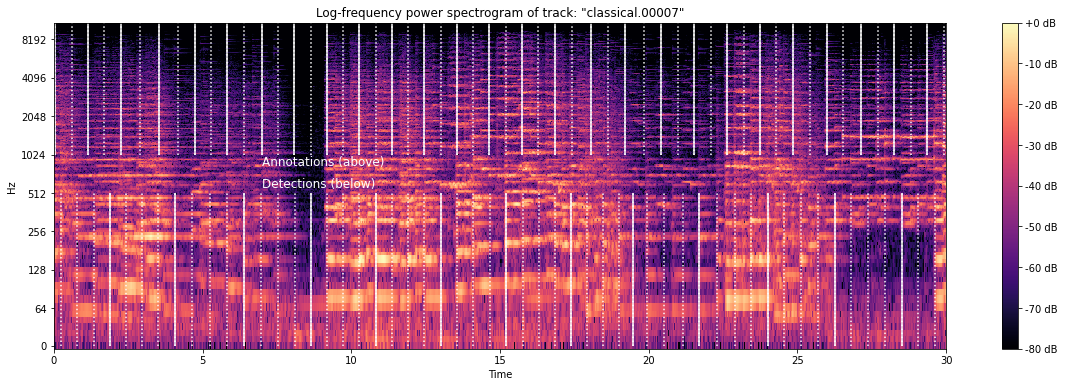

In [38]:
song = test.ids[0]

det = detections[song]

track = tracks[song]
audio, sr = track.audio
hop_length = 512

spec = librosa.amplitude_to_db(np.abs(librosa.stft(audio, hop_length=hop_length)), ref=np.max)
librosa.display.specshow(spec, y_axis='log', sr=sr, hop_length=hop_length, x_axis='time')
plt.title(f'Log-frequency power spectrogram of track: "{song}"')
plt.colorbar(format="%+2.f dB")
# plot annotations in the upper part
plt.vlines(track.beats.times, hop_length * 2, sr / 2, linestyles='dotted', color='w')
plt.vlines(track.beats.times[track.beats.positions == 1], hop_length * 2, sr / 2, color='w')
plt.text(7, hop_length * 1.65, 'Annotations (above)', color='w', fontsize=12)
# plot detections in the lower part
plt.vlines(det['downbeats'][:, 0], 0, hop_length, linestyles='dotted', color='w')
plt.vlines(det['downbeats'][det['downbeats'][:, 1] == 1][:, 0], 0, hop_length, color='w')
plt.text(7, hop_length * 1.1, 'Detections (below)', color='w', fontsize=12)
plt.show()

In [39]:
from scipy.io import wavfile
from scipy.signal import resample
import IPython

beat_sr, beat = wavfile.read(f'{PATH}Datasets/DL/Project/Metronome/beat.wav')
downbeat_sr, downbeat = wavfile.read(f'{PATH}Datasets/DL/Project/Metronome/downbeat.wav')
output = det['downbeats']
sample_rate = track.audio[1]
audio = track.audio[0]
num_samples = len(audio)

beat = beat.astype(np.float32)/32768.0
downbeat = downbeat.astype(np.float32)/32768.0

beat_length_sample = beat.shape[0]
downbeat_length_sample = downbeat.shape[0]

audio_with_beats = audio
beat_sequence = np.zeros(num_samples)

for i in range(len(output)):
    beat_start_sample = int(output[i][0]*sample_rate)
    beat_position = output[i][1]
    if beat_position == 1:
        beat_end_sample = beat_start_sample + downbeat_length_sample
        beat_sequence[beat_start_sample:beat_end_sample] = downbeat[:beat_sequence[beat_start_sample:beat_end_sample].shape[0]]
    else:
        beat_end_sample = beat_start_sample + beat_length_sample
        beat_sequence[beat_start_sample:beat_end_sample] = beat[:beat_sequence[beat_start_sample:beat_end_sample].shape[0]]

audio_scale_factor = (np.amax(beat_sequence) - np.amin(beat_sequence))/(np.amax(audio_with_beats)-np.amin(audio_with_beats))        
audio_with_beats = audio_scale_factor*0.4*audio_with_beats + 0.5*beat_sequence
IPython.display.display(IPython.display.Audio(audio,rate=sample_rate))
IPython.display.display(IPython.display.Audio(audio_with_beats,rate=sample_rate))

# Data augmentation

Using only very few songs often results in poor generalisation.
To increase the amount of training data without requiring more annotated data, data augmentation can be used.

We use a simple approach of adding the same training examples with changed hop-size when computing the STFT.
This results in the same song being represented with a different numbers of frames.
This way the beat positions are "streched" or "squeezed" and the tempo changes accordingly.

In [ ]:
# # RUN ONLY IF YOU WANT TO RE-TRAIN THE NETWORK
# for fps in [95, 97.5, 102.5, 105]:
#     ds = DataSequence(
#         tracks={f'{k}_{fps}': v for k, v in tracks.items() if k in train_files},
#         pre_processor=PreProcessor(fps=fps),
#         pad_frames=pad_frames,
#     )
#     ds.widen_beat_targets()
#     ds.widen_downbeat_targets()
#     ds.widen_tempo_targets(3, 0.5)
#     ds.widen_tempo_targets(3, 0.5)
#     train.append(ds)

# print(len(train))

processing track 274/700: jazz.00004_95                    

jazz.00003_95 has no downbeat information, masking



processing track 278/700: jazz.00010_95                    

jazz.00009_95 has no downbeat information, masking



processing track 279/700: jazz.00011_95                    

jazz.00010_95 has no downbeat information, masking



processing track 284/700: jazz.00019_95                    

jazz.00018_95 has no downbeat information, masking



processing track 286/700: jazz.00021_95                    

jazz.00020_95 has no downbeat information, masking



processing track 293/700: jazz.00032_95                    

jazz.00031_95 has no valid tempo (362.7107858733694), masking



processing track 545/700: reggae.00087_95                    

reggae.00086_95 has no beat information, skipping



processing track 274/700: jazz.00004_97.5                    

jazz.00003_97.5 has no downbeat information, masking



processing track 278/700: jazz.00010_97.5                    

jazz.00009_97.5 has no downbeat information, masking



processing track 279/700: jazz.00011_97.5                    

jazz.00010_97.5 has no downbeat information, masking



processing track 284/700: jazz.00019_97.5                    

jazz.00018_97.5 has no downbeat information, masking



processing track 286/700: jazz.00021_97.5                    

jazz.00020_97.5 has no downbeat information, masking



processing track 293/700: jazz.00032_97.5                    

jazz.00031_97.5 has no valid tempo (353.1116074123257), masking



processing track 545/700: reggae.00087_97.5                    

reggae.00086_97.5 has no beat information, skipping



processing track 274/700: jazz.00004_102.5                    

jazz.00003_102.5 has no downbeat information, masking



processing track 278/700: jazz.00010_102.5                    

jazz.00009_102.5 has no downbeat information, masking



processing track 279/700: jazz.00011_102.5                    

jazz.00010_102.5 has no downbeat information, masking



processing track 284/700: jazz.00019_102.5                    

jazz.00018_102.5 has no downbeat information, masking



processing track 286/700: jazz.00021_102.5                    

jazz.00020_102.5 has no downbeat information, masking



processing track 293/700: jazz.00032_102.5                    

jazz.00031_102.5 has no valid tempo (337.37451313840586), masking



processing track 545/700: reggae.00087_102.5                    

reggae.00086_102.5 has no beat information, skipping



processing track 274/700: jazz.00004_105                    

jazz.00003_105 has no downbeat information, masking



processing track 278/700: jazz.00010_105                    

jazz.00009_105 has no downbeat information, masking



processing track 279/700: jazz.00011_105                    

jazz.00010_105 has no downbeat information, masking



processing track 284/700: jazz.00019_105                    

jazz.00018_105 has no downbeat information, masking



processing track 286/700: jazz.00021_105                    

jazz.00020_105 has no downbeat information, masking



processing track 293/700: jazz.00032_105                    

jazz.00031_105 has no valid tempo (327.8688524590164), masking



processing track 545/700: reggae.00087_105                    

reggae.00086_105 has no beat information, skipping



processing track 700/700: metal.00098_105                    

3495


## Re-train network

In [ ]:
# # RUN ONLY IF YOU WANT TO RE-TRAIN THE NETWORK
# epochs = 50
# verbose = 0
# num_features = 20

# setting = 'baseline_1_train_augmented_attempt_2'

# # create output dir
# outdir = f'{PATH}Datasets/DL/Project/{setting}'
# os.makedirs(outdir, exist_ok=True)
# print(f'output dir: {outdir}')

# # model checkpointing
# mc = keras.callbacks.ModelCheckpoint(f'{outdir}/model_best.h5', monitor='loss', save_best_only=True, verbose=verbose)

# # early stopping
# es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-4, patience=20, verbose=verbose)

# # tensorboard logging
# tb = keras.callbacks.TensorBoard(log_dir=f'{outdir}/logs', write_graph=True, write_images=True)

# # learn rate scheduler
# lr = keras.callbacks.ReduceLROnPlateau(
#     monitor='loss', factor=0.2, patience=10, verbose=1, mode='auto', min_delta=1e-3, cooldown=0, min_lr=1e-7
# )

# # train network
# history = model.fit_generator(
#     train,
#     steps_per_epoch=len(train),
#     epochs=epochs,
#     shuffle=True,
#     validation_data=val,
#     validation_steps=len(val),
#     callbacks=[mc, es, tb, lr],
# )
# model.save(f'{outdir}/model_final.h5')

output dir: /content/drive/My Drive/Datasets/DL/Project/baseline_1_train_augmented_attempt_1
Epoch 1/50
3495/3495 [==============================] - 237s 68ms/step - loss: 0.1501 - beats_loss: 0.0935 - downbeats_loss: 0.0366 - tempo_loss: 0.0200 - beats_binary_accuracy: 0.9435 - downbeats_binary_accuracy: 0.9777 - tempo_binary_accuracy: 0.9821 - val_loss: 0.1592 - val_beats_loss: 0.0984 - val_downbeats_loss: 0.0376 - val_tempo_loss: 0.0232 - val_beats_binary_accuracy: 0.9440 - val_downbeats_binary_accuracy: 0.9849 - val_tempo_binary_accuracy: 0.9834 - lr: 1.0000e-03
Epoch 2/50
3495/3495 [==============================] - 219s 63ms/step - loss: 0.1480 - beats_loss: 0.0926 - downbeats_loss: 0.0361 - tempo_loss: 0.0193 - beats_binary_accuracy: 0.9436 - downbeats_binary_accuracy: 0.9777 - tempo_binary_accuracy: 0.9821 - val_loss: 0.1594 - val_beats_loss: 0.0993 - val_downbeats_loss: 0.0376 - val_tempo_loss: 0.0225 - val_beats_binary_accuracy: 0.9440 - val_downbeats_binary_accuracy: 0.9849 

In [40]:
# Loading model -- if you have trained the model, no need to load it.
setting = 'baseline_1_train_augmented_attempt_1'
outdir = f'{PATH}Datasets/DL/Project/{setting}'
print(f'output dir: {outdir}')
model = keras.models.load_model(f'{outdir}/model_final.h5', compile=False)

output dir: /content/drive/My Drive/Datasets/DL/Project/baseline_1_train_augmented_attempt_1


## Re-predict on test set

In [41]:
# create a directory to put the activations and detections into
detdir = f'{outdir}/detections/'

# make predictions for the held-out test set
activations, detections = predict(model, test, detdir)

processing file 1 of 150: classical.00007 


1/1 [==============================] - 1s 865ms/step


processing file 2 of 150: classical.00008 


1/1 [==============================] - 0s 26ms/step


processing file 3 of 150: classical.00009 


1/1 [==============================] - 0s 26ms/step


processing file 4 of 150: classical.00011 


1/1 [==============================] - 0s 36ms/step


processing file 5 of 150: classical.00021 


1/1 [==============================] - 0s 24ms/step


processing file 6 of 150: classical.00024 


1/1 [==============================] - 0s 24ms/step


processing file 7 of 150: classical.00042 


1/1 [==============================] - 1s 1s/step


processing file 8 of 150: classical.00047 


1/1 [==============================] - 0s 31ms/step


processing file 9 of 150: classical.00060 


1/1 [==============================] - 0s 36ms/step


processing file 10 of 150: classical.00062 


1/1 [==============================] - 0s 42ms/step


processing file 11 of 150: classical.00065 


1/1 [==============================] - 0s 25ms/step


processing file 12 of 150: classical.00066 


1/1 [==============================] - 0s 24ms/step


processing file 13 of 150: classical.00067 


1/1 [==============================] - 0s 23ms/step


processing file 14 of 150: classical.00072 


1/1 [==============================] - 0s 27ms/step


processing file 15 of 150: classical.00078 


1/1 [==============================] - 0s 24ms/step


processing file 16 of 150: classical.00083 


1/1 [==============================] - 0s 37ms/step


processing file 17 of 150: classical.00089 


1/1 [==============================] - 0s 24ms/step


processing file 18 of 150: classical.00093 


1/1 [==============================] - 0s 24ms/step


processing file 19 of 150: classical.00099 


1/1 [==============================] - 0s 24ms/step


processing file 20 of 150: country.00000 


1/1 [==============================] - 0s 28ms/step


processing file 21 of 150: country.00008 


1/1 [==============================] - 0s 29ms/step


processing file 22 of 150: country.00009 


1/1 [==============================] - 0s 26ms/step


processing file 23 of 150: country.00018 


1/1 [==============================] - 0s 36ms/step


processing file 24 of 150: country.00024 


1/1 [==============================] - 0s 25ms/step


processing file 25 of 150: country.00028 


1/1 [==============================] - 0s 25ms/step


processing file 26 of 150: country.00037 


1/1 [==============================] - 0s 23ms/step


processing file 27 of 150: country.00041 


1/1 [==============================] - 0s 30ms/step


processing file 28 of 150: country.00043 


1/1 [==============================] - 0s 24ms/step


processing file 29 of 150: country.00046 


1/1 [==============================] - 0s 34ms/step


processing file 30 of 150: country.00047 


1/1 [==============================] - 0s 23ms/step


processing file 31 of 150: country.00048 


1/1 [==============================] - 0s 23ms/step


processing file 32 of 150: country.00056 


1/1 [==============================] - 0s 25ms/step


processing file 33 of 150: country.00059 


1/1 [==============================] - 0s 24ms/step


processing file 34 of 150: country.00060 


1/1 [==============================] - 0s 28ms/step


processing file 35 of 150: country.00075 


1/1 [==============================] - 0s 38ms/step


processing file 36 of 150: country.00076 


1/1 [==============================] - 0s 36ms/step


processing file 37 of 150: country.00087 


1/1 [==============================] - 0s 26ms/step


processing file 38 of 150: country.00088 


1/1 [==============================] - 0s 24ms/step


processing file 39 of 150:  disco.00005 


1/1 [==============================] - 0s 32ms/step


processing file 40 of 150:  disco.00006 


1/1 [==============================] - 0s 24ms/step


processing file 41 of 150:  disco.00014 


1/1 [==============================] - 0s 24ms/step


processing file 42 of 150:  disco.00019 


1/1 [==============================] - 0s 36ms/step


processing file 43 of 150:  disco.00026 


1/1 [==============================] - 0s 24ms/step


processing file 44 of 150:  disco.00027 


1/1 [==============================] - 0s 23ms/step


processing file 45 of 150:  disco.00030 


1/1 [==============================] - 0s 27ms/step


processing file 46 of 150:  disco.00040 


1/1 [==============================] - 0s 24ms/step


processing file 47 of 150:  disco.00045 


1/1 [==============================] - 0s 23ms/step


processing file 48 of 150:  disco.00062 


1/1 [==============================] - 0s 40ms/step


processing file 49 of 150:  disco.00066 


1/1 [==============================] - 0s 38ms/step


processing file 50 of 150:  disco.00071 


1/1 [==============================] - 0s 25ms/step


processing file 51 of 150:  disco.00072 


1/1 [==============================] - 0s 30ms/step


processing file 52 of 150:  disco.00081 


1/1 [==============================] - 0s 24ms/step


processing file 53 of 150:  disco.00087 


1/1 [==============================] - 0s 25ms/step


processing file 54 of 150: hiphop.00007 


1/1 [==============================] - 0s 26ms/step


processing file 55 of 150: hiphop.00010 


1/1 [==============================] - 0s 34ms/step


processing file 56 of 150: hiphop.00015 


1/1 [==============================] - 0s 27ms/step


processing file 57 of 150: hiphop.00019 


1/1 [==============================] - 0s 24ms/step


processing file 58 of 150: hiphop.00020 


1/1 [==============================] - 0s 23ms/step


processing file 59 of 150: hiphop.00022 


1/1 [==============================] - 0s 24ms/step


processing file 60 of 150: hiphop.00026 


1/1 [==============================] - 0s 24ms/step


processing file 61 of 150: hiphop.00041 


1/1 [==============================] - 0s 46ms/step


processing file 62 of 150: hiphop.00057 


1/1 [==============================] - 0s 24ms/step


processing file 63 of 150: hiphop.00063 


1/1 [==============================] - 0s 24ms/step


processing file 64 of 150: hiphop.00066 


1/1 [==============================] - 0s 25ms/step


processing file 65 of 150: hiphop.00073 


1/1 [==============================] - 0s 23ms/step


processing file 66 of 150: hiphop.00075 


1/1 [==============================] - 0s 23ms/step


processing file 67 of 150: hiphop.00078 


1/1 [==============================] - 0s 26ms/step


processing file 68 of 150: hiphop.00082 


1/1 [==============================] - 0s 39ms/step


processing file 69 of 150: hiphop.00095 


1/1 [==============================] - 0s 23ms/step


processing file 70 of 150:   jazz.00013 


1/1 [==============================] - 0s 25ms/step


processing file 71 of 150:   jazz.00014 


1/1 [==============================] - 0s 25ms/step


processing file 72 of 150:   jazz.00016 


1/1 [==============================] - 0s 28ms/step


processing file 73 of 150:   jazz.00023 


1/1 [==============================] - 0s 28ms/step


processing file 74 of 150:   jazz.00027 


1/1 [==============================] - 0s 36ms/step


processing file 75 of 150:   jazz.00028 


1/1 [==============================] - 0s 27ms/step


processing file 76 of 150:   jazz.00043 


1/1 [==============================] - 0s 23ms/step


processing file 77 of 150:   jazz.00044 


1/1 [==============================] - 0s 29ms/step


processing file 78 of 150:   jazz.00053 


1/1 [==============================] - 0s 26ms/step


processing file 79 of 150:   jazz.00073 


1/1 [==============================] - 0s 24ms/step


processing file 80 of 150:   jazz.00084 


1/1 [==============================] - 0s 25ms/step


processing file 81 of 150:   jazz.00085 


1/1 [==============================] - 0s 44ms/step


processing file 82 of 150:   jazz.00092 


1/1 [==============================] - 0s 24ms/step


processing file 83 of 150:   rock.00002 


1/1 [==============================] - 0s 24ms/step


processing file 84 of 150:   rock.00023 


1/1 [==============================] - 0s 25ms/step


processing file 85 of 150:   rock.00025 


1/1 [==============================] - 0s 26ms/step


processing file 86 of 150:   rock.00036 


1/1 [==============================] - 0s 25ms/step


processing file 87 of 150:   rock.00037 


1/1 [==============================] - 0s 34ms/step


processing file 88 of 150:   rock.00055 


1/1 [==============================] - 0s 24ms/step


processing file 89 of 150:   rock.00076 


1/1 [==============================] - 0s 24ms/step


processing file 90 of 150:   rock.00078 


1/1 [==============================] - 0s 26ms/step


processing file 91 of 150:   rock.00081 


1/1 [==============================] - 0s 24ms/step


processing file 92 of 150:   rock.00082 


1/1 [==============================] - 0s 25ms/step


processing file 93 of 150:   rock.00087 


1/1 [==============================] - 0s 36ms/step


processing file 94 of 150:   rock.00089 


1/1 [==============================] - 0s 46ms/step


processing file 95 of 150:  blues.00007 


1/1 [==============================] - 0s 25ms/step


processing file 96 of 150:  blues.00018 


1/1 [==============================] - 0s 25ms/step


processing file 97 of 150:  blues.00032 


1/1 [==============================] - 0s 25ms/step


processing file 98 of 150:  blues.00035 


1/1 [==============================] - 0s 24ms/step


processing file 99 of 150:  blues.00037 


1/1 [==============================] - 0s 25ms/step


processing file 100 of 150:  blues.00052 


1/1 [==============================] - 0s 36ms/step


processing file 101 of 150:  blues.00075 


1/1 [==============================] - 0s 25ms/step


processing file 102 of 150:  blues.00076 


1/1 [==============================] - 0s 30ms/step


processing file 103 of 150:  blues.00078 


1/1 [==============================] - 0s 24ms/step


processing file 104 of 150:  blues.00088 


1/1 [==============================] - 0s 24ms/step


processing file 105 of 150:  blues.00098 


1/1 [==============================] - 0s 26ms/step


processing file 106 of 150: reggae.00004 


1/1 [==============================] - 0s 35ms/step


processing file 107 of 150: reggae.00009 


1/1 [==============================] - 0s 25ms/step


processing file 108 of 150: reggae.00012 


1/1 [==============================] - 0s 24ms/step


processing file 109 of 150: reggae.00015 


1/1 [==============================] - 0s 25ms/step


processing file 110 of 150: reggae.00020 


1/1 [==============================] - 0s 25ms/step


processing file 111 of 150: reggae.00025 


1/1 [==============================] - 0s 25ms/step


processing file 112 of 150: reggae.00039 


1/1 [==============================] - 0s 25ms/step


processing file 113 of 150: reggae.00042 


1/1 [==============================] - 0s 37ms/step


processing file 114 of 150: reggae.00065 


1/1 [==============================] - 0s 28ms/step


processing file 115 of 150: reggae.00067 


1/1 [==============================] - 0s 27ms/step


processing file 116 of 150: reggae.00073 


1/1 [==============================] - 0s 24ms/step


processing file 117 of 150: reggae.00074 


1/1 [==============================] - 0s 25ms/step


processing file 118 of 150: reggae.00082 


1/1 [==============================] - 0s 25ms/step


processing file 119 of 150: reggae.00090 


1/1 [==============================] - 0s 44ms/step


processing file 120 of 150:    pop.00009 


1/1 [==============================] - 0s 42ms/step


processing file 121 of 150:    pop.00033 


1/1 [==============================] - 0s 26ms/step


processing file 122 of 150:    pop.00035 


1/1 [==============================] - 0s 29ms/step


processing file 123 of 150:    pop.00044 


1/1 [==============================] - 0s 24ms/step


processing file 124 of 150:    pop.00048 


1/1 [==============================] - 0s 25ms/step


processing file 125 of 150:    pop.00053 


1/1 [==============================] - 0s 25ms/step


processing file 126 of 150:    pop.00060 


1/1 [==============================] - 0s 40ms/step


processing file 127 of 150:    pop.00061 


1/1 [==============================] - 0s 24ms/step


processing file 128 of 150:    pop.00078 


1/1 [==============================] - 0s 25ms/step


processing file 129 of 150:    pop.00081 


1/1 [==============================] - 0s 25ms/step


processing file 130 of 150:    pop.00082 


1/1 [==============================] - 0s 24ms/step


processing file 131 of 150:    pop.00083 


1/1 [==============================] - 0s 26ms/step


processing file 132 of 150:    pop.00085 


1/1 [==============================] - 0s 39ms/step


processing file 133 of 150:    pop.00087 


1/1 [==============================] - 0s 34ms/step


processing file 134 of 150:    pop.00088 


1/1 [==============================] - 0s 25ms/step


processing file 135 of 150:    pop.00095 


1/1 [==============================] - 0s 25ms/step


processing file 136 of 150:    pop.00099 


1/1 [==============================] - 0s 27ms/step


processing file 137 of 150:  metal.00002 


1/1 [==============================] - 0s 24ms/step


processing file 138 of 150:  metal.00005 


1/1 [==============================] - 0s 39ms/step


processing file 139 of 150:  metal.00006 


1/1 [==============================] - 0s 40ms/step


processing file 140 of 150:  metal.00007 


1/1 [==============================] - 0s 26ms/step


processing file 141 of 150:  metal.00029 


1/1 [==============================] - 0s 24ms/step


processing file 142 of 150:  metal.00032 


1/1 [==============================] - 0s 36ms/step


processing file 143 of 150:  metal.00033 


1/1 [==============================] - 0s 25ms/step


processing file 144 of 150:  metal.00036 


1/1 [==============================] - 0s 26ms/step


processing file 145 of 150:  metal.00052 


1/1 [==============================] - 0s 35ms/step


processing file 146 of 150:  metal.00053 


1/1 [==============================] - 0s 23ms/step


processing file 147 of 150:  metal.00058 


1/1 [==============================] - 0s 25ms/step


processing file 148 of 150:  metal.00072 


1/1 [==============================] - 0s 26ms/step


processing file 149 of 150:  metal.00083 


1/1 [==============================] - 0s 25ms/step


processing file 150 of 150:  metal.00087 


1/1 [==============================] - 0s 27ms/step


## Re-evaluate beats & tempo

When comparing the model's performance trained with data augmentation to the original model, one should keep in mind that depending on the nature of the dataset (i.e. style of songs, tempo distribution, etc.) data augmentation might not lead to increased performance at all, especially if only very training examples are used.

In [42]:
beat_detections = {k: v['beats'] for k, v in detections.items()}
downbeat_detections = {k: v['downbeats'] for k, v in detections.items()}
bar_detections = {k: v['bars'] for k, v in detections.items()}
tempo_detections = {k: v['tempo'][0, 0] for k, v in detections.items()}

beat_annotations = {k: v.beats.times for k, v in tracks.items() if v.beats is not None}
downbeat_annotations = {k: v.beats.times[v.beats.positions == 1] for k, v in tracks.items() if v.beats is not None}
tempo_annotations = {k: v.tempo for k, v in tracks.items() if v.tempo is not None}

# evaluate beats
print('Beat evaluation\n---------------')
print(' Beat tracker:    ', evaluate_beats(beat_detections, beat_annotations))
print(' Downbeat tracker:', evaluate_beats(downbeat_detections, beat_annotations))

# evaluate downbeats
print('\nDownbeat evaluation\n-------------------')
print(' Bar tracker:     ', evaluate_downbeats(bar_detections, downbeat_annotations))
print(' Downbeat tracker:', evaluate_downbeats(downbeat_detections, downbeat_annotations))

# evaluate tempo
print('\nTempo evaluation\n----------------')
print(' Tempo:           ', evaluate_tempo(tempo_detections, tempo_annotations))

Beat evaluation
---------------
 Beat tracker:     mean for 150 files
  F-measure: 0.892 P-score: 0.889 Cemgil: 0.841 Goto: 0.867 CMLc: 0.806 CMLt: 0.833 AMLc: 0.891 AMLt: 0.921 D: 3.303 Dg: 2.280
 Downbeat tracker: mean for 150 files
  F-measure: 0.889 P-score: 0.885 Cemgil: 0.837 Goto: 0.873 CMLc: 0.805 CMLt: 0.830 AMLc: 0.887 AMLt: 0.917 D: 3.288 Dg: 2.249

Downbeat evaluation
-------------------
 Bar tracker:      mean for 150 files
  F-measure: 0.690 P-score: 0.711 Cemgil: 0.655 Goto: 0.680 CMLc: 0.668 CMLt: 0.669 AMLc: 0.847 AMLt: 0.848 D: 4.544 Dg: 2.770
 Downbeat tracker: mean for 150 files
  F-measure: 0.689 P-score: 0.714 Cemgil: 0.653 Goto: 0.680 CMLc: 0.670 CMLt: 0.670 AMLc: 0.865 AMLt: 0.865 D: 4.522 Dg: 2.817

Tempo evaluation
----------------
 Tempo:            mean for 150 files
  pscore=0.873 (one tempo: 0.873, all tempi: 0.873) acc1=0.873 acc2=0.920


(ISMIR 2021 Tutorial) The impact of data augmentation can be better observed with a model model trained on the full GTZAN dataset:
```
Beat evaluation
---------------
 Beats:     mean for 20 files
  F-measure: 0.909 P-score: 0.914 Cemgil: 0.845 Goto: 0.950 CMLc: 0.860 CMLt: 0.909 AMLc: 0.883 AMLt: 0.945 D: 3.511 Dg: 2.515
 Downbeats: mean for 20 files
  F-measure: 0.904 P-score: 0.910 Cemgil: 0.841 Goto: 0.950 CMLc: 0.859 CMLt: 0.905 AMLc: 0.883 AMLt: 0.941 D: 3.489 Dg: 2.470

Downbeat evaluation
-------------------
 Bars:      mean for 20 files
  F-measure: 0.681 P-score: 0.755 Cemgil: 0.639 Goto: 0.750 CMLc: 0.742 CMLt: 0.742 AMLc: 0.916 AMLt: 0.916 D: 4.702 Dg: 3.228
 Downbeats: mean for 20 files
  F-measure: 0.661 P-score: 0.743 Cemgil: 0.616 Goto: 0.750 CMLc: 0.729 CMLt: 0.729 AMLc: 0.912 AMLt: 0.912 D: 4.613 Dg: 3.031

Tempo evaluation
----------------
 Tempo:      mean for 20 files
  pscore=0.950 (one tempo: 0.950, all tempi: 0.950) acc1=0.950 acc2=0.950
```


Our Model
```
Beat evaluation
---------------
 Beat tracker:     mean for 150 files
  F-measure: 0.892 P-score: 0.889 Cemgil: 0.841 Goto: 0.867 CMLc: 0.806 CMLt: 0.833 AMLc: 0.891 AMLt: 0.921 D: 3.303 Dg: 2.280
 Downbeat tracker: mean for 150 files
  F-measure: 0.889 P-score: 0.885 Cemgil: 0.837 Goto: 0.873 CMLc: 0.805 CMLt: 0.830 AMLc: 0.887 AMLt: 0.917 D: 3.288 Dg: 2.249

Downbeat evaluation
-------------------
 Bar tracker:      mean for 150 files
  F-measure: 0.690 P-score: 0.711 Cemgil: 0.655 Goto: 0.680 CMLc: 0.668 CMLt: 0.669 AMLc: 0.847 AMLt: 0.848 D: 4.544 Dg: 2.770
 Downbeat tracker: mean for 150 files
  F-measure: 0.689 P-score: 0.714 Cemgil: 0.653 Goto: 0.680 CMLc: 0.670 CMLt: 0.670 AMLc: 0.865 AMLt: 0.865 D: 4.522 Dg: 2.817

Tempo evaluation
----------------
 Tempo:            mean for 150 files
  pscore=0.873 (one tempo: 0.873, all tempi: 0.873) acc1=0.873 acc2=0.920
```

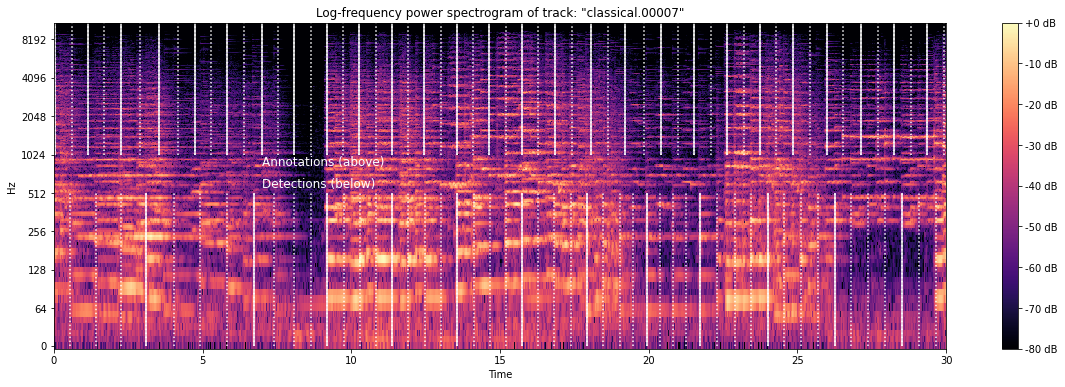

In [43]:
song = test.ids[0]

det = detections[song]

track = tracks[song]
audio, sr = track.audio
hop_length = 512

spec = librosa.amplitude_to_db(np.abs(librosa.stft(audio, hop_length=hop_length)), ref=np.max)
librosa.display.specshow(spec, y_axis='log', sr=sr, hop_length=hop_length, x_axis='time')
plt.title(f'Log-frequency power spectrogram of track: "{song}"')
plt.colorbar(format="%+2.f dB")
# plot annotations in the upper part
plt.vlines(track.beats.times, hop_length * 2, sr / 2, linestyles='dotted', color='w')
plt.vlines(track.beats.times[track.beats.positions == 1], hop_length * 2, sr / 2, color='w')
plt.text(7, hop_length * 1.65, 'Annotations (above)', color='w', fontsize=12)
# plot detections in the lower part
plt.vlines(det['downbeats'][:, 0], 0, hop_length, linestyles='dotted', color='w')
plt.vlines(det['downbeats'][det['downbeats'][:, 1] == 1][:, 0], 0, hop_length, color='w')
plt.text(7, hop_length * 1.1, 'Detections (below)', color='w', fontsize=12)
plt.show()

In [44]:
from scipy.io import wavfile
from scipy.signal import resample
import IPython

beat_sr, beat = wavfile.read(f'{PATH}Datasets/DL/Project/Metronome/beat.wav')
downbeat_sr, downbeat = wavfile.read(f'{PATH}Datasets/DL/Project/Metronome/downbeat.wav')
output = det['downbeats']
sample_rate = track.audio[1]
audio = track.audio[0]
num_samples = len(audio)

beat = beat.astype(np.float32)/32768.0
downbeat = downbeat.astype(np.float32)/32768.0

beat_length_sample = beat.shape[0]
downbeat_length_sample = downbeat.shape[0]

audio_with_beats = audio
beat_sequence = np.zeros(num_samples)

for i in range(len(output)):
    beat_start_sample = int(output[i][0]*sample_rate)
    beat_position = output[i][1]
    if beat_position == 1:
        beat_end_sample = beat_start_sample + downbeat_length_sample
        beat_sequence[beat_start_sample:beat_end_sample] = downbeat[:beat_sequence[beat_start_sample:beat_end_sample].shape[0]]
    else:
        beat_end_sample = beat_start_sample + beat_length_sample
        beat_sequence[beat_start_sample:beat_end_sample] = beat[:beat_sequence[beat_start_sample:beat_end_sample].shape[0]]

audio_scale_factor = (np.amax(beat_sequence) - np.amin(beat_sequence))/(np.amax(audio_with_beats)-np.amin(audio_with_beats))        
audio_with_beats = audio_scale_factor*0.4*audio_with_beats + 0.5*beat_sequence
IPython.display.display(IPython.display.Audio(audio,rate=sample_rate))
IPython.display.display(IPython.display.Audio(audio_with_beats,rate=sample_rate))

In [48]:
!pip freeze > /content/drive/MyDrive/Datasets/DL/Project/requirements.txt

In [51]:
!python --version

Python 3.9.16
